# Generate MNIST Largest Number Dataset

## Constants

In [1]:
import numpy as np
import os
import tensorflow as tf
import random as rn
from keras import backend as K

# Set random seeds EVERYWHERE:
seed = 123
rand = np.random.RandomState(seed)
os.environ['PYTHONHASHSEED'] = '{}'.format(rand.randint(2**32))
np.random.seed(rand.randint(2**32))
rn.seed(rand.randint(2**32))
tf.set_random_seed(rand.randint(2**32))

# Make TensorFlow deterministic:
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Even after all this machinery the weights are only ε-close

Using TensorFlow backend.


In [2]:
# How many MNIST numbers should be available for sampling in the end?
test_size = 60000

# Final dataset:
n_train = 10000
n_test = 10000
n_objects = 10
n_features = 128

output_name = 'largest_mnist'

## Feature extraction

### Import MNIST

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home="./")
X_raw = mnist['data'].reshape(-1, 28, 28) / 255.
y = mnist['target']
num_classes = len(np.unique(y))
num_classes

10

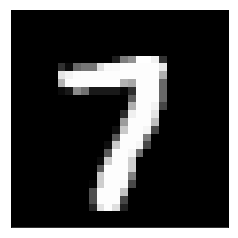

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plot_file =  "image.svg"
fig, ax = plt.subplots()
ax.imshow(X_raw[68016], cmap = 'gray')
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.savefig(plot_file, dpi=None, facecolor='w', edgecolor='w', orientation='portrait', format='svg')

### Split into Train/test

In [6]:
from sklearn.model_selection import train_test_split
X_raw_train, X_raw_test, y_train, y_test = train_test_split(
    X_raw, y,
    test_size=test_size,
    random_state=rand,
    stratify=y
)

### Train CNN for feature extraction

In [7]:
import keras
from keras import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD
from keras.regularizers import l2

regularizer = l2(1e-4)

input_shape = (28, 28, 1)

#model = Sequential()
inp = Input(input_shape)
tr = Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape,
                 kernel_regularizer=regularizer,
                 use_bias=False)(inp)
tr = MaxPooling2D()(tr)
tr = BatchNormalization()(tr)
tr = Conv2D(64, (5, 5), activation='relu',
                 kernel_regularizer=regularizer,
                 use_bias=False)(tr)
tr = MaxPooling2D()(tr)
tr = BatchNormalization()(tr)
tr = Flatten()(tr)
tr = Dense(1024, activation='relu', kernel_regularizer=regularizer, use_bias=False)(tr)
tr = BatchNormalization()(tr)
tr = Dense(n_features, activation='relu', kernel_regularizer=regularizer)(tr)
tr = BatchNormalization()(tr)
out = Dense(num_classes, activation='softmax', kernel_regularizer=regularizer)(tr)
model = Model(inputs=inp, outputs=out)
model_feat = Model(inputs=inp, outputs=tr)

from keras.callbacks import LearningRateScheduler

def schedule(ep):
    if ep < 10:
        return 1e-2
    if ep < 20:
        return 1e-3
    return 1e-4
lrschedule = LearningRateScheduler(schedule)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=SGD(lr=1e-3, momentum=0.9, nesterov=True), metrics=['accuracy'],
              )

In [8]:
model.fit(X_raw_train[..., None], keras.utils.to_categorical(y_train, num_classes),
          batch_size=64, epochs=15, verbose=1, validation_split=0.1, callbacks=[lrschedule])

Train on 9000 samples, validate on 1000 samples
Epoch 1/15
9000/9000 [==============================] - 23s 3ms/step - loss: 0.3575 - acc: 0.9301 - val_loss: 0.2420 - val_acc: 0.9630
Epoch 2/15
9000/9000 [==============================] - 22s 2ms/step - loss: 0.1818 - acc: 0.9871 - val_loss: 0.2332 - val_acc: 0.9670
Epoch 3/15
9000/9000 [==============================] - 21s 2ms/step - loss: 0.1513 - acc: 0.9962 - val_loss: 0.2166 - val_acc: 0.9710
Epoch 4/15
9000/9000 [==============================] - 22s 2ms/step - loss: 0.1439 - acc: 0.9978 - val_loss: 0.2181 - val_acc: 0.9740
Epoch 5/15
9000/9000 [==============================] - 21s 2ms/step - loss: 0.1381 - acc: 0.9996 - val_loss: 0.2075 - val_acc: 0.9730
Epoch 6/15
9000/9000 [==============================] - 22s 2ms/step - loss: 0.1354 - acc: 0.9999 - val_loss: 0.2075 - val_acc: 0.9770
Epoch 7/15
9000/9000 [==============================] - 22s 2ms/step - loss: 0.1333 - acc: 1.0000 - val_loss: 0.2079 - val_acc: 0.9780
Epoch 8

### Use CNN to transform images to high-level features

In [9]:
X_raw_feat = model_feat.predict(X_raw_test[...,None])

In [12]:
np.save("X_raw_features.npy", X_raw_feat)
np.save("y_labels.npy", y_test)

In [13]:
X_raw_feat.shape

(60000, 128)

## Sample numbers

In [40]:
n_total = n_train + n_test
largest_numbers = rand.randint(1, num_classes, size=n_total)
X = np.empty((n_total, n_objects, n_features))
y_number = np.empty((n_total, n_objects), dtype=int)
for i in range(n_total):
    remaining = X_raw_feat[y_test <= largest_numbers[i]]
    while True:
        indeces = rand.choice(len(remaining), size=n_objects, replace=False)
        X[i] = remaining[indeces]
        y_number[i] = y_test[y_test <= largest_numbers[i]][indeces]
        if largest_numbers[i] in y_number[i]:
            break

In [41]:
y = (y_number == largest_numbers[:, None]).astype(int)

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=rand, test_size=n_test)

### Output files

In [43]:
np.save("{}_X_train.npy".format(output_name), X_train)
np.save("{}_X_test.npy".format(output_name), X_test)
np.save("{}_Y_train.npy".format(output_name), Y_train)
np.save("{}_Y_test.npy".format(output_name), Y_test)